# An introduction to decision trees

## 1. Game of Thrones example

### 1.1 Generate and pre-process the data

In the following code block, we generate a data set with just one variable, "age", to mimick our "Game of Thrones" tree example. 

In [1]:
import random
import pandas as pd
import numpy as np
np.random.seed(0)

#This code is provided 
random.seed(123)
age_0 = pd.DataFrame([19])
age_1 = pd.DataFrame(sorted(random.sample(range(18, 50), 20)))
age_2 = pd.DataFrame(sorted(random.sample(range(35, 70), 20)))
age_3 = pd.DataFrame([68])

age = age_0.append(age_1, ignore_index= True)
age = age.append(age_2, ignore_index= True)
age = age.append(age_3, ignore_index= True)


label_1 = pd.DataFrame([1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
label_2 = pd.DataFrame([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0])


label = label_1.append(label_2, ignore_index=True)
data = pd.concat([age, label], axis=1)

data.columns = ['age', 'label']

This data is created in such a way that the data is not perfectly separable, and also in a way that younger people seem to be more likely to watch the show.

In [15]:
data.head()

,age,label
0,19,1
1,19,0
2,20,1
3,21,0
4,22,1


In [16]:
data.tail()

,age,label
37,64,0
38,65,1
39,67,0
40,68,1
41,68,0


### 1.2  Manually create a split

We'll try to manually calculate what the "perfect split" is for this data set, so we'll basically try to recreate the first "split" in the decision tree from our lab. Let's show it again:

![title](G_of_T_tree.png)

Is 41 the best split? Let's find out! You'll create 3 functions in total:
- A function `split()` which splits up the data set in a way that you can easily compute the gini for the two "children" of the parent node, given a split value.
- A function `gini_score()`, which, given a certain split, computes the gini for the left node, the gini for the right node, and the purity gain
- A function `best_split()` which loops over the former two functions to find the best split. 

Let's start by creating the `split()` function. This function takes three arguments, the first one is the column name, which should be a string, the second one is the value that represents the split (in this example, representing a certain age), and as a third argument the name of the data set.

In the cell below, complete the `split` function. This function will take in a column name, value, and a DataFrame.  For any data in the named column less than or equal to `value` parameter, the function should store these rows in a variable called `data_left`.  Any rows with a value in `col_name` greater than `value` should be stored in `data_right`.  The function should return `data_left, data_right`.

In [18]:
def split(col_name, value, data):
    #split the data in 2 given a column name and the value
    data_left = data[data[col_name]<=value]
    data_right = data[data[col_name]>value]
    return data_left, data_right

Let's use our newly created function on the column "age" (for this data the only option), and look at the age 44.

In [19]:
data_left, data_right = split('age',44,data)

Now, inspect `data_left` and `data_right`.

In [28]:
data_left.head()

,age,label
0,19,1
1,19,0
2,20,1
3,21,0
4,22,1


In [30]:
data_right.tail()

,age,label
37,64,0
38,65,1
39,67,0
40,68,1
41,68,0


### Gini Score

Next, we'll create a function to determine the **_gini score_** for a given split.  

Complete the `gini_score` function in the cell below.  Since this function is a bit complicated, comments have been provided to help simplify writing it. 

`gini_score` should:
* Determine the size of each split, as well as the total number of samples.
* Determine the probability of seeing a given outcome (watches or doesn't watch GoT) in both splits. 
* Square the probability and sum then sum the squares for a given node. 
* Calculate the gini coefficient for both splits (1 minus the value calculated in the last step)
* Calculate the weighted gini scores for each side by multiplying the proportion of the total sample that side makes up (size of side / number of total samples).
* Calculate the gain by adding the two weighted gini scores together.  

In [67]:
def gini_score(data_left, data_right):
    
    # amount of instances flowing in the left vs right node
    size_left= len(data_left)
    size_right = len(data_right)
    n_samples = size_left+size_right
    
    # respective chances of seeing each outcome in the left vs right node 
    p_0L = np.sum(data_left.label==0)/size_left
    p_1L = np.sum(data_left.label==1)/size_left
    p_0R = np.sum(data_right.label==0)/size_right
    p_1R = np.sum(data_right.label==1)/size_right
  
    #take the squares and sum over each node
    score_L = p_0L**2 + p_1L**2
    score_R = p_0R**2 + p_1R**2
    
    # left node and right node ginis
    gini_L = 1 - score_L
    gini_R = 1 - score_R
    
    #weighted ginis
    weight_gini_L = gini_L * size_left/n_samples
    weight_gini_R = gini_R * size_right/n_samples
    
    # The gains (here, we don't compute the root gini again. This value should be mimimized.)
    gain = weight_gini_L + weight_gini_R
    return gini_L, gini_R, gain

Now, let's call our function on the split we've already made to test that everything works.  

In the cell below, call `gini_score` and pass in `data_left` and `data_right`.

In [68]:
gini_score(data_left,data_right)
# Expected Output: (0.4444444444444444, 0.4012345679012346, 0.42592592592592593)

(0.4444444444444444, 0.4012345679012346, 0.42592592592592593)

### Determining the Optimal Split,

Now that we have a function to split our data on a given value, and another function to determine how good this split using gini score, we'll write one more function to find the split that produces the best possible gini scores,
    
In the cell below, complete the best split function.  As with the previous function, we have included comments to help make coding it less complicated.
   
The function should:
* Determine the range of the search space (between the minimum and maximum values that column contains)
* Iterate through that search space.  For every value:
* Split the data using our split function
* Calculate the for each side of the split, as well as the gain
    * If the gain is better (lower) than the current best score, update the `best` values,
* When every possible value in search space has been tested, return an `output` dictionary containing the best value to split on, the best gain score, the best splits, and the best gini scores for those groups. 


In [69]:
def best_split(data, col_name):
    # make sure you have the correct range to loop over
    min_val = data[col_name].min()
    max_val = data[col_name].max()
    best_score = 999
    # loop over all the ages 
    for i in range(min_val, max_val):
        data_left, data_right = split(col_name,i,data)
        gini_l, gini_r, gain = gini_score(data_left,data_right)
        # update if gain is lower than any previously observed gain 
        if gain < best_score:
            best_val = i
            best_score = gain
            best_groups = data_left,data_right
            best_ginis= gini_l,gini_r
    output = {}
    # create a dictionary with the best value, the best gain, the best groups and the best ginis
    output['val'] = best_val
    output['gain'] = best_score
    output['groups'] = best_groups 
    output['ginis'] = best_ginis

    return output

Now, let's test that our new function works.

In [80]:
best_output = best_split(data, "age")
best_output['ginis']
split_age = best_output['val']

split_age

49

#### Optional

Uncomment and run the cell below to get a better idea for what the `best_split` function is actually doing during each iteration of the loop. 

In [82]:
#If you want to see what's going on in each loop...
min_age=19
max_age=68
for i in range(min_age, max_age):
    data_left, data_right = split("age", i, data)
    data_l,data_r, gini = gini_score(data_left, data_right)
    print(i)   
    print(gini)

19
0.5
20
0.49572649572649574
21
0.5
22
0.4972972972972973
23
0.4907407407407407
24
0.4907407407407407
25
0.4907407407407407
26
0.48163265306122455
27
0.48163265306122455
28
0.47058823529411764
29
0.4579124579124579
30
0.44375
31
0.4281524926686217
32
0.4281524926686217
33
0.4281524926686217
34
0.4281524926686217
35
0.4350132625994695
36
0.45408163265306134
37
0.45673076923076916
38
0.4583333333333333
39
0.4590909090909091
40
0.44444444444444436
41
0.44444444444444436
42
0.42727272727272725
43
0.42727272727272725
44
0.42592592592592593
45
0.4423529411764706
46
0.4230769230769231
47
0.4395061728395062
48
0.4183673469387755
49
0.4111111111111111
50
0.4281524926686217
51
0.4281524926686217
52
0.4281524926686217
53
0.44375
54
0.4579124579124579
55
0.4579124579124579
56
0.4579124579124579
57
0.4579124579124579
58
0.4579124579124579
59
0.47058823529411764
60
0.48163265306122455
61
0.48163265306122455
62
0.4907407407407407
63
0.4972972972972973
64
0.5
65
0.49572649572649574
66
0.4957264957264

### 1.3 Use scikit learn and verify answer

We'll use scikit-learn to create a decision tree. 

Run the cell below to import the `tree` module from sklearn.

In [83]:
from sklearn import tree

Now, create a `DecisionTreeClassifier` object. When creating the tree, set the `criterion` equal to `gini`, and the `max_depth` equal to `1`.

In [84]:
clf_GoT = tree.DecisionTreeClassifier(criterion='gini',max_depth=1)

Now we can use `clf.fit` with "age" as a first argument and "label" as a second argument. If you only have 1 predictor, you need to reshape your predictor using `.reshape(-1, 1)`. 

Run the cell below to fit our Decision Tree Classifier object to the data.

In [88]:
GoT_tree = clf_GoT.fit(data['age'].values.reshape(-1, 1), data['label'])

In [89]:
GoT_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Optional: Visualize the Fitted Decision Tree

Some 3rd party libraries make it easy to create a visual representation of our fitted Decision Tree Classifier.  Run the cell below to create the visualization.

**_NOTE:_**  The code below relies on a library called `graphviz` which is notoriously troublesome to get working on some machines. If the code doesn't work immediately, feel free to try and debug it by googling the error message--if it doesn't work, it's probably only because you need to install a missing dependency. If you can't get the visualization to work, feel free to skip this section!

In [100]:
#Uncomment this code and run this cell to visualize the Tree
import graphviz 
from sklearn.tree import export_graphviz
GoT_graph = tree.export_graphviz(GoT_tree, out_file=None) 
graph = graphviz.Source(GoT_graph)

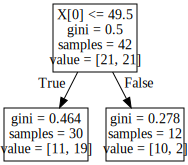

In [101]:
# Uncomment this code and run this cell to visualize the Tree
export_graphviz(GoT_tree, out_file="mytree.dot")
with open("mytree.dot") as f: dot_graph = f.read()
graphviz.Source(dot_graph)

We see that scikit learn generated the same split! Now, let's verify if we computed the correct gini measures. 

## 2. US salaries data set

### 2.1 Data pre-processing

The salary data set was extracted from the census bureau database and contains salary information. The goal is to use this data set and to try to draw conclusions regarding what drives salaries. More specifically, the target variable is categorical (> 50k; <= 50 k)

In [102]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [103]:
salaries = pd.read_csv("salaries_final.csv", index_col = 0)

In [104]:
salaries.tail()

,Age,Education,Occupation,Relationship,Race,Sex,Target
32556,27,Assoc-acdm,Tech-support,Wife,White,Female,<=50K
32557,40,HS-grad,Machine-op-inspct,Husband,White,Male,>50K
32558,58,HS-grad,Adm-clerical,Unmarried,White,Female,<=50K
32559,22,HS-grad,Adm-clerical,Own-child,White,Male,<=50K
32560,52,HS-grad,Exec-managerial,Wife,White,Female,>50K


The dataset "salaries" contains 6 predictors, and one outcome variable, the target salary <= 50k/ >50k.

The 6 predictors are:
- `Age`: continuous.

- `Education`: Categorical. Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, 
Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

- `Occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

- `Relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

- `Race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

- `Sex`: Female, Male.

It's important to know that scikit learn needs to get dummies as an input for categorical variables. Luckily, we can use the `dmatrices` from the patsy library to get our data in the correct shape. From our 7 predictors, we only have 2 continuous variables ("Age" and "Education-Num"). The other 5 are all categorical.

In order to deal use categorical data in the model, we'll need to **_One-Hot Encode_** the categorical data by creating boolean dummy columns for each different category in each categorical column. Pandas provides a way to do this, but we'll explore that in a further lab.  In this lab, we'll make use of the `patsy` library's `dmatrices` module. 

Run the cell below to split our target from the dataset, and transform our dataset into a one-hot encoded version. 

In [105]:
from patsy import dmatrices
target, data = dmatrices('Target ~ Age + C(Education) + \
                  C(Occupation) + C(Relationship) + C(Race) + C(Sex)',
                  salaries, return_type = "dataframe")

Now, use the appropriate method to split our our data and labels into training and testing sets. 

In [106]:
data_train, data_test,target_train, target_test = train_test_split(data, target, 
                                                                   test_size = 0.25)

### 2.2 Creating trees

Now that we have prepared our data, we'll create a large Decision Tree to see how it does.

In the cell below, create a `DecisionTreeClassifier` object, and set the `criterion` parameter to `'gini'`, as well as the `max_depth` parameter to `12`.

Then, run the cell below it to `fit()` our model to the data.

In [112]:
from sklearn import tree

sal_tree = tree.DecisionTreeClassifier(criterion='gini',max_depth=12)
sal_tree.fit(data_train, target_train.iloc[:,1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [113]:
# Optional: Uncomment this cell and run it to visualize our trained model. 
import graphviz 
from sklearn.tree import export_graphviz
export_graphviz(sal_tree, out_file="mytree.dot", feature_names=data_train.columns , class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Smaller Trees

Let's examine if there's a difference with smaller trees.  

In the cell below, create a Decision Tree Classifier as we did before, but this time set the `max_depth` to `3`.  Still set the `criterion` to `gini`. Then, `.fit()` the smaller model to our training data (see the cell above if you are unsure of the syntax).

In [114]:
sal_tree_smaller = tree.DecisionTreeClassifier(max_depth=3)
sal_tree_smaller.fit(data_train, target_train.iloc[:,1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

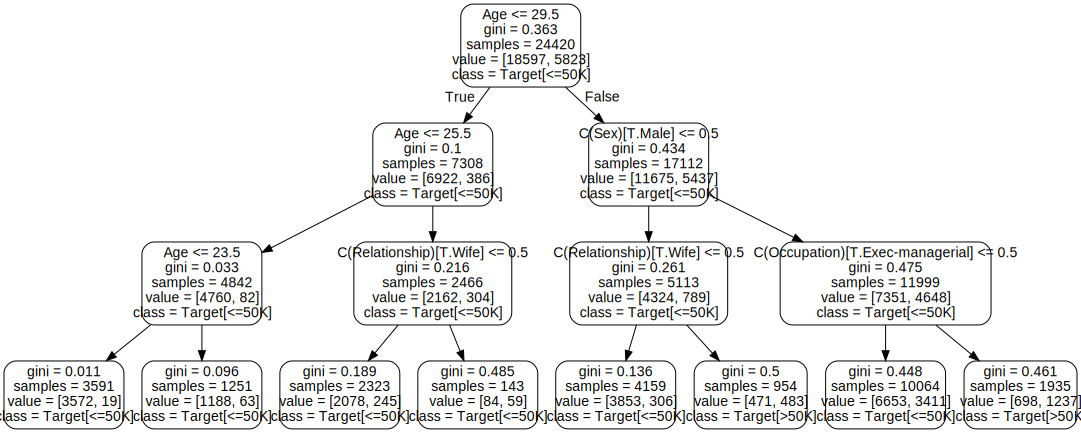

In [115]:
# Optional: Uncomment this cell and run it to visualize our trained model. 
export_graphviz(sal_tree_smaller, out_file="mytree.dot", feature_names=data_train.columns ,
                class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Most leaf nodes will point to <= 50 k. How is this possible?
A class imbalance in our dataset! 5865 make more than 50k, while 18555 make less (~25 vs 75%)

Note how the left nodes always point to "true" and the right nodes to "false".

### 2.3 Model performance

Now that we have trained models, let's evaluate the performance of each. 

Run the cell below to import the `accuracy_score` helper method.  Then, run the cell below to create some sample predictions on our testing data and generate a `confusion_matrix` and a `classification_report` based on the predictions.  


In [116]:
from sklearn.metrics import accuracy_score

In [124]:
pred= sal_tree.predict(data_test)
print(metrics.confusion_matrix(target_test.iloc[:,1], pred))
print(metrics.classification_report(target_test.iloc[:,1], pred))

[[5537  586]
 [ 936 1082]]
             precision    recall  f1-score   support

        0.0       0.86      0.90      0.88      6123
        1.0       0.65      0.54      0.59      2018

avg / total       0.80      0.81      0.81      8141



In [118]:
accuracy_score(target_test.iloc[:,1], pred)

0.8130450804569463

In [125]:
pred_smaller = sal_tree_smaller.predict(data_test)
print(metrics.confusion_matrix(target_test.iloc[:,1], pred_smaller))
print(metrics.classification_report(target_test.iloc[:,1], pred_smaller))

[[5752  371]
 [1465  553]]
             precision    recall  f1-score   support

        0.0       0.80      0.94      0.86      6123
        1.0       0.60      0.27      0.38      2018

avg / total       0.75      0.77      0.74      8141



Now, run the cell below to generate an accuracy score for our predictions.

In [126]:
accuracy_score(target_test.iloc[:,1], pred_smaller)

0.7744748802358432

### Pre-Tuning

One of the best ways to tune Decision Trees to prevent **_overfitting_** is to pre-tune the model by providing constraints on certain aspects of the Decision Tree. Decision Trees are famously prone to overfitting, and tuning the model to be more general can help prevent this. 

The following parameters are the most commonly used for tuning.  In a later lab, you'll learn how to automate the search for the best parameters for each. 

- criterion: either gini for gini impurity, or entropy for information gain.
- max_depth: the maximum depth of a tree.
- min_samples_split: minimum amount of samples required to split an internal node.
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
- class_weight: Weights associated with classes.

In [139]:
from sklearn import tree
sal_tree_tuned= tree.DecisionTreeClassifier(criterion = "gini",
                                            max_depth = 12, min_samples_split = 300, min_samples_leaf = 150)
sal_tree_tuned = sal_tree_tuned.fit(data_train, target_train.iloc[:,1])

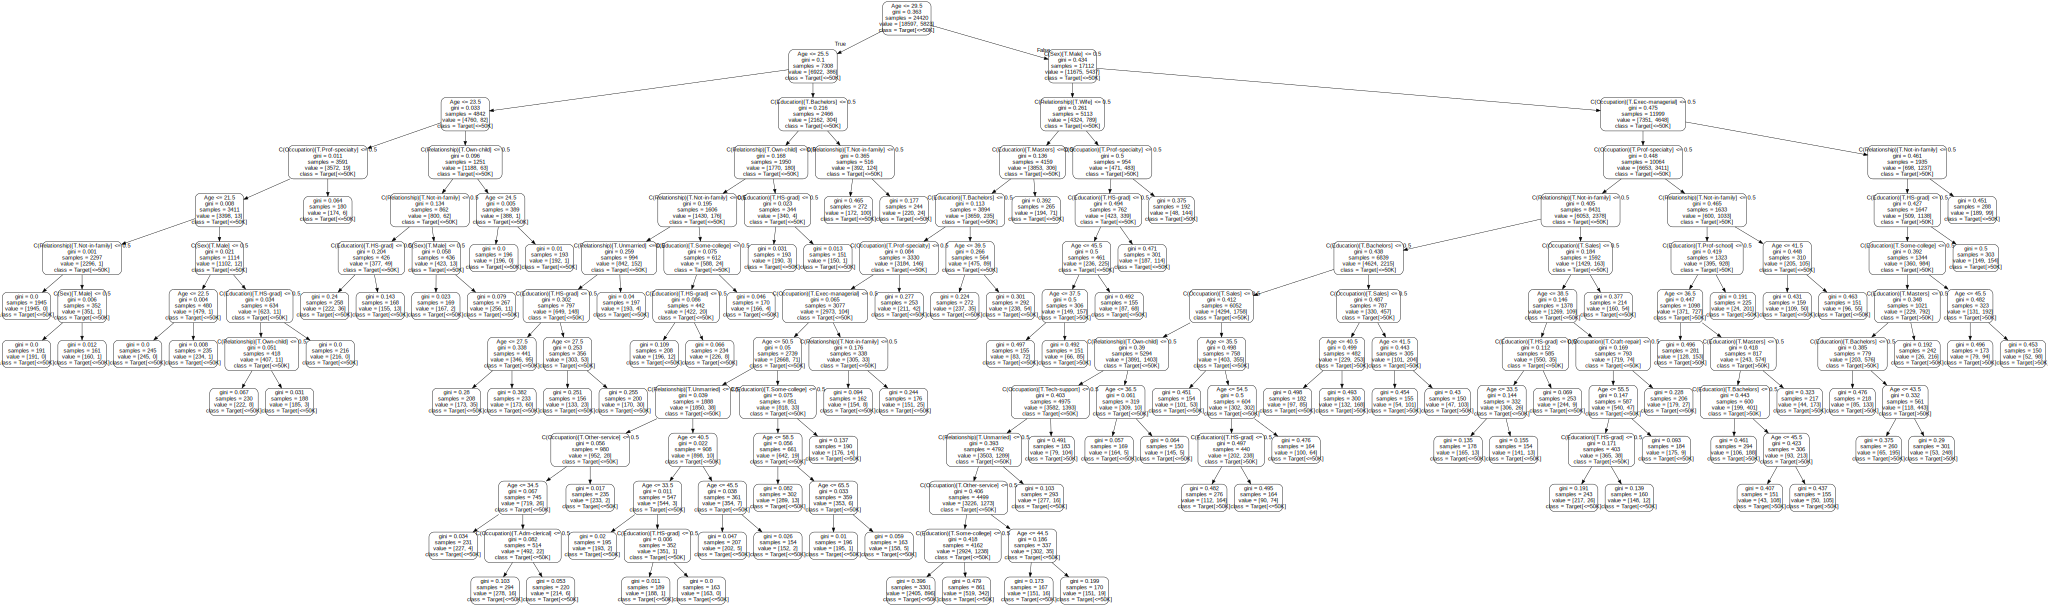

In [136]:
# Optional: Uncomment this cell and run it to visualize our trained model. 
export_graphviz(sal_tree_tuned, out_file="mytree.dot", feature_names=data_train.columns , 
                class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Now, run the cell below so we can see how well the pre-tuned model did.

In [140]:
pred_tuned = sal_tree_tuned.predict(data_test)
print(metrics.confusion_matrix(target_test.iloc[:,1], pred_tuned))
print(metrics.classification_report(target_test.iloc[:,1], pred_tuned))

accuracy_score(target_test.iloc[:,1], pred_tuned)

[[5623  500]
 [1018 1000]]
             precision    recall  f1-score   support

        0.0       0.85      0.92      0.88      6123
        1.0       0.67      0.50      0.57      2018

avg / total       0.80      0.81      0.80      8141



0.8135364205871515

For this deep tree: better result with pruning!

# Sources
https://www.svds.com/machine-learning-vs-statistics/ 

https://github.com/xbno/Projects/blob/master/Models_Scratch/Decision%20Trees%20from%20scratch.ipynb

https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

http://scikit-learn.org/stable/modules/tree.html